In [1]:
from langchain_groq import ChatGroq
from sentence_transformers import SentenceTransformer
import os
import getpass
import weaviate
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
import json
import operator
from typing import List, Annotated
from langgraph.graph import END
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# Kết nối các API
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        return os.environ[var]
    
_set_env("LANGCHAIN_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("GROQ_API_KEY")
WEAVIATE_URL = _set_env("WEAVIATE_URL")
WEAVIATE_API_KEY = _set_env("WEAVIATE_API_KEY")
# Kết nối langchain và websearch
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "QA-answering"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"

# Kết nối CSDL vector

client = weaviate.Client(url=WEAVIATE_URL                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ,
                        auth_client_secret=weaviate.auth.AuthApiKey(api_key=WEAVIATE_API_KEY))

In [10]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        return os.environ[var]
_set_env("TAVILY_API_KEY")

'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'

In [ ]:
embedding_model = SentenceTransformer('dangvantuan/vietnamese-embedding', device='cpu')

In [ ]:
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=1024,
    timeout=None,
    max_retries=2)

llm_json_mode = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=1024,
    timeout=None,
    response_format={"type": "json_object"})

In [2]:
rag_prompt = """Bạn là một cố vấn học tập cho các nhiệm vụ trả lời câu hỏi của sinh viên đại học.
Sau đây là ngữ cảnh để sử dụng để trả lời câu hỏi:
{context}
Hãy suy nghĩ cẩn thận về ngữ cảnh trên.
Bây giờ, hãy xem lại câu hỏi của người dùng:
{question}
Hãy suy nghĩ kỹ sau đó mới cung cấp câu trả lời cho câu hỏi này chỉ bằng ngữ cảnh trên chỉ bằng các chữ A,B,C,D là phương án và có giải thích thật ngắn gọn, không lặp lại. Nếu không biết đáp án chỉ cần ghi "Không biết".
Trả lời:"""

router_instruction = """Bạn là chuyên gia trong việc định tuyến câu hỏi của người dùng đến vectorstore hoặc tìm kiếm trên web.
Vectorstore chứa các tài liệu liên quan đến quy định và học tập của Đại học Bách khoa Hà Nội.
Sử dụng vectorstore cho các câu hỏi về các chủ đề này. Đối với tất cả các chủ đề khác, và đặc biệt là các sự kiện hiện tại, hãy sử dụng web-search.
Trả về JSON với khóa duy nhất, nguồn dữ liệu, tức là 'websearch' hoặc 'vectorstore' tùy thuộc vào câu hỏi."""

doc_grader_instructions = """Bạn là người chấm điểm đánh giá mức độ liên quan của một tài liệu đã truy xuất đến câu hỏi của người dùng.
Nếu tài liệu chứa từ khóa hoặc ý nghĩa ngữ nghĩa liên quan đến câu hỏi, hãy chấm điểm là có liên quan."""

# Prompt chấm điểm
doc_grader_prompt = """Đây là tài liệu đã truy xuất: \n\n {document} \n\n Đây là câu hỏi của người dùng: \n\n {question}.
Điều này đánh giá cẩn thận và khách quan xem tài liệu có chứa ít nhất một số thông tin có liên quan đến câu hỏi hay không.
Trả về JSON với khóa đơn, binary_score, tức là đánh giá 'yes' hoặc 'no' để chỉ ra liệu tài liệu có chứa ít nhất một số thông tin có liên quan đến câu hỏi hay không."""

hallucination_grader_instructions = """
Bạn là giáo viên chấm bài kiểm tra.
Bạn sẽ được cung cấp SỰ THẬT và CÂU TRẢ LỜI CỦA HỌC SINH.
Sau đây là tiêu chí chấm điểm cần tuân theo:

(1) Đảm bảo CÂU TRẢ LỜI CỦA HỌC SINH dựa trên SỰ THẬT.
(2) Đảm bảo CÂU TRẢ LỜI CỦA HỌC SINH không chứa thông tin "ảo giác" nằm ngoài phạm vi của SỰ THẬT.

Điểm:
Điểm 'yes' có nghĩa là câu trả lời của học sinh đáp ứng tất cả các tiêu chí. Đây là điểm cao nhất (tốt nhất).
Điểm 'no' có nghĩa là câu trả lời của học sinh không đáp ứng tất cả các tiêu chí. Đây là điểm thấp nhất có thể mà bạn có thể cho.
Giải thích lý luận của bạn theo từng bước để đảm bảo lý luận và kết luận của bạn là đúng.
Tránh chỉ nêu câu trả lời đúng ngay từ đầu."""

hallucination_grader_prompt = """SỰ THẬT: \n\n {documents} \n\n CÂU TRẢ LỜI CỦA HỌC SINH: {generation}.

Trả về JSON với hai khóa, binary_score là điểm 'yes' hoặc 'no' để chỉ ra liệu CÂU TRẢ LỜI CỦA HỌC SINH có dựa trên SỰ THẬT hay không. Và một khóa, giải thích, chứa giải thích về điểm số."""

answer_grader_instructions = """Bạn là giáo viên chấm bài kiểm tra.

Bạn sẽ được đưa ra một CÂU HỎI và một CÂU TRẢ LỜI CỦA HỌC SINH.
Sau đây là tiêu chí chấm điểm cần tuân theo:

(1) CÂU TRẢ LỜI CỦA HỌC SINH giúp trả lời CÂU HỎI

Điểm:
Điểm 'yes' nghĩa là câu trả lời của học sinh đáp ứng tất cả các tiêu chí. Đây là điểm cao nhất (tốt nhất).
Học sinh có thể nhận được điểm có nếu câu trả lời có chứa thông tin bổ sung không được yêu cầu rõ ràng trong câu hỏi.
Điểm 'no' có nghĩa là câu trả lời của học sinh không đáp ứng tất cả các tiêu chí. Đây là điểm thấp nhất có thể mà bạn có thể cho.
Giải thích lý do của bạn theo từng bước để đảm bảo lý do và kết luận của bạn là đúng.
Tránh chỉ nêu câu trả lời đúng ngay từ đầu."""

answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}.
Trả về JSON với hai khóa, binary_score là điểm 'yes' hoặc 'no' để chỉ ra liệu STUDENT ANSWER có đáp ứng tiêu chí hay không. 
Và một khóa, giải thích, chứa giải thích về điểm số."""

In [3]:
# Tìm kiếm tài liệu bằng Weaviate
def search(query,k):
  query_embedding = embedding_model.encode(query)
  result =(
    client.query
    .get("Document", ["title","content"])
    .with_hybrid(
        query=query,
        vector=query_embedding
    )
    .with_limit(k)
    .do()
)
  docs=[]
  
  for content in result["data"]["Get"]["Document"]:
    docs.append(Document(page_content= content['content']))
  return docs

In [5]:
from IPython.display import Image, display
from typing_extensions import TypedDict

class chat_state(TypedDict):
    question: str  
    generation: str  
    web_search: str  
    max_retries: int  
    answers: int  
    loop_step: Annotated[int, operator.add]
    documents: List[str]

In [6]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [11]:
web_search_tool = TavilySearchResults(k=3)
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


### Nodes
def retrieve(state):

    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = search(question)
    return {"documents": documents}

#Generate
def generate(state):

    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


def grade_documents(state):

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}


def web_search(state):
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}

def route_question(state):
    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instruction)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

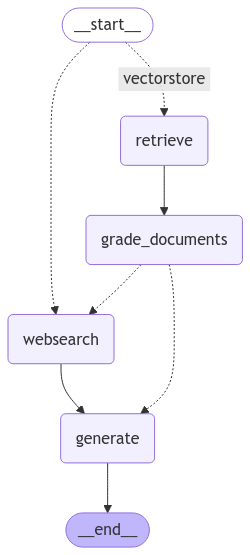

In [15]:
#Ghép các cấu phần

workflow = StateGraph(chat_state)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge(
    "generate",END
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import pandas as pd
faq = pd.read_excel("FAQ.xlsx")
faq

In [ ]:
# Test on current events
import time
states_test = []
i=0
for question in FAQ:
    if i == 2:
      time.sleep(60)
      i = 0
    states_test.append([])
    inputs = {
        "question": question+"\nChọn đáp án đúng",
        "max_retries": 0,
    }

    for event in graph.stream(inputs, stream_mode="values"):
        states_test[-1].append(event)
    i += 1

In [ ]:
messages = []
for state in states_test:
    messages.append({'question': state[-1]['question'],
                     'generation':state[-1]['generation'].content})

In [ ]:
import pandas as pd
df = pd.DataFrame(messages)

In [ ]:
df.to_excel("FAiQ.xlsx")